# Ablation Study: Parallelization and Update Schedules
In this ablation study we compare the performances of ATT parallelized with *entangled parallelization* (EP), i.e. the interactive scheme suggested in the paper, versus *naive parallelization* (NP), i.e. the use of independent ATT chains. Moreover, we consider the interplay of this parallelization choice with the possible use of *update schedules* (US), where the absence of an update schedule is taken to mean that a sampler must update its parameters in every iteration.

As the target distribution, we use the Gaussian $\nu = \mathcal{N}_d(\tau,\Pi)$ with $\tau = (1,...,d)^T \in \mathbb{R}^d$ and $\Pi = \text{diag}(1^2,...,d^2)^T$, in dimension $d = 100$.

In [1]:
from patt_mcmc import patt_gpss
from att_mcmc import npatt_gpss
import mcmc_utils as mcu
import plotting_functions as pfs

In [2]:
from time import time
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path_prefix = "../plots/ablation_study_par_up_sched_"

### Construct Target Density

In [4]:
d = 100
c = np.arange(1,d+1)
std = np.arange(1,d+1)

def log_density(x):
    return -1/2 * alg.norm((x - c) / std)**2

### Run the Samplers

In [5]:
n_chains = 10
n_burn = 0
n_its = int(2e4)
# draw initial states from target to avoid needing burn-in
x_0s = rnd.multivariate_normal(mean = c, cov = np.diag(std**2), size=n_chains)
w = np.sqrt(d)

In [6]:
trivial_schedule = np.arange(2, n_its, dtype=int)
augd_trivial_schedule = np.concatenate([np.array([1]), trivial_schedule, np.array([n_its+1])])

**Note:** In the variable names chosen below we encode the use of non-trivial parallelization and update schedules in a Boolean fashion, i.e. with two letters, each either $\texttt{y}$ (yes) or $\texttt{n}$ (no) denoting whether the respective approach was used.

#### NP without US

In [7]:
time_nn = -time()
ret_dic = npatt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="mean",
    cov_mode="var",
    schedule=trivial_schedule,
    w_att=w,
)
time_nn += time()

Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████████████████████████████████████████████| 20001/20001 [00:07<00:00, 2806.68it/s]


Processing returns and assembling output...


In [8]:
samples_nn = ret_dic['samples']
means_nn = ret_dic['means']
stds_nn = ret_dic['std_devs']
schedule_nn = augd_trivial_schedule
tde_nn = ret_dic['tde_cnts']

#### NP+US

In [9]:
time_ny = -time()
ret_dic = npatt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="mean",
    cov_mode="var",
    w_att=w,
)
time_ny += time()

Preparing for parallel sampling...
Starting parallel sampling...


100%|██████████████████████████████████████████████████████████████████████████| 20001/20001 [00:04<00:00, 4698.04it/s]


Processing returns and assembling output...


In [10]:
samples_ny = ret_dic['samples']
means_ny = ret_dic['means']
stds_ny = ret_dic['std_devs']
schedule_ny = ret_dic['schedule']
tde_ny = ret_dic['tde_cnts']

#### EP without US

In [11]:
time_yn = -time()
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="mean",
    cov_mode="var",
    schedule=trivial_schedule,
    w_att=w,
)
time_yn += time()

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/20001 [00:00<?, ?it/s]

Assembling output...


In [12]:
samples_yn = ret_dic['samples']
means_yn = ret_dic['means']
stds_yn = ret_dic['std_devs']
schedule_yn = augd_trivial_schedule
tde_yn = ret_dic['tde_cnts']

#### EP+US

In [13]:
time_yy = -time()
ret_dic = patt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="mean",
    cov_mode="var",
    w_att=w,
)
time_yy += time()

Checking validity of given arguments...
Preparing for parallel sampling...
Preparing for ATT sampling...
Starting ATT sampling...


  0%|          | 0/20001 [00:00<?, ?it/s]

Assembling output...


In [14]:
samples_yy = ret_dic['samples']
means_yy = ret_dic['means']
stds_yy = ret_dic['std_devs']
schedule_yy = ret_dic['schedule']
tde_yy = ret_dic['tde_cnts']

### Analyze Sampling Performance

In [15]:
snames = ["NP without US", "NP+US", "EP without US", "EP+US"]
times = np.array([time_nn, time_ny, time_yn, time_yy])
samples = [samples_nn, samples_ny, samples_yn, samples_yy]
tde = [tde_nn, tde_ny, tde_yn, tde_yy]
means = [means_nn, means_ny, means_yn, means_yy]
stds = [stds_nn, stds_ny, stds_yn, stds_yy]
schedules = [schedule_nn, schedule_ny, schedule_yn, schedule_yy]
nsam = len(snames)

In [16]:
radii = mcu.get_radii_list(samples)
flat_steps = mcu.get_flat_steps_list(samples)

In [17]:
mean_tde = mcu.mean_tde_list(tde)
maxls = [1000, 1000, 100, 100]
mean_iats = mcu.mean_iat_multi_chain_list(samples, maxls)
msss = mcu.mss_list(samples)

In [18]:
pd.DataFrame(
    np.array([
        snames,
        np.round(times, 2),
        np.round(mean_tde, 2),
        np.round(mean_iats, 2),
        np.round(msss, 2),
        np.round((n_chains * n_its / mean_iats) / times, 2), # = (total samples)/IAT / time = ES/time
    ]).T,
    columns = [
        "Sampler",
        "CPU time",
        "TDE/it",
        "mean IAT",
        "MSS",
        "ES/s",
    ]
)

,Sampler,CPU time,TDE/it,mean IAT,MSS,ES/s
0,NP without US,7.79,8.68,35.53,381.4,722.3
1,NP+US,4.42,8.46,27.37,454.48,1654.9
2,EP without US,96.99,6.64,1.1,723.16,1872.85
3,EP+US,4.67,7.12,3.29,678.5,13001.5


### Plotting

In [19]:
figsize = (3,2)
dpi = 250

In [20]:
default_cycler = plt.rcParams["axes.prop_cycle"]
colors = plt.cm.viridis(np.linspace(0, 0.9, nsam))
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", colors)

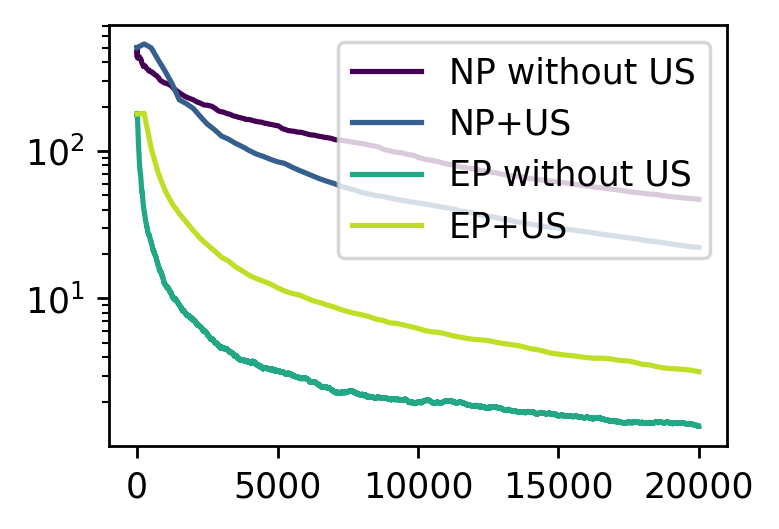

In [21]:
pfs.initiate(figsize, dpi)
plt.yscale("log")
for i in range(nsam):
    if len(means[i].shape) == 2:
        mean_devs = alg.norm(means[i] - c, axis=-1)
        plt.plot(schedules[i], mean_devs)
    else:
        mean_devs = alg.norm(means[i][0] - c, axis=-1)
        plt.plot(schedules[i], mean_devs)
plt.legend(snames, loc="upper right")
pfs.wrapup(path_prefix + "mean_devs.png")

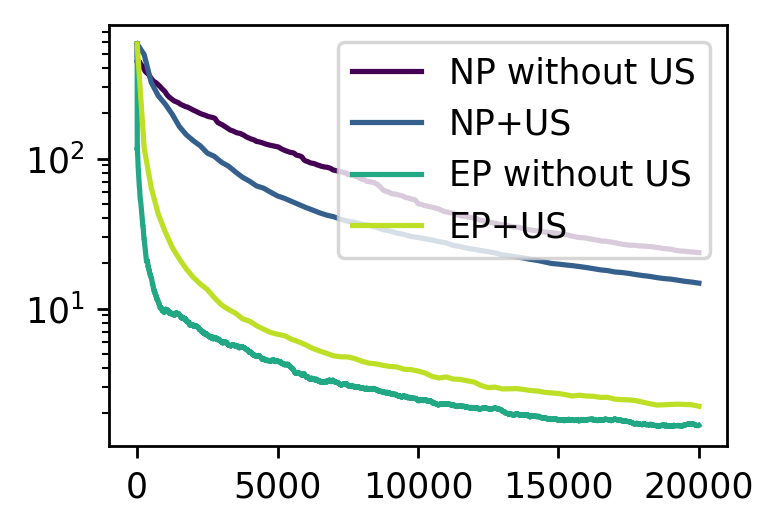

In [22]:
pfs.initiate(figsize, dpi)
plt.yscale("log")
for i in range(nsam):
    if len(means[i].shape) == 2:
        std_devs = alg.norm(stds[i] - std, axis=-1)
        plt.plot(schedules[i], std_devs)
    else:
        std_devs = alg.norm(stds[i][0] - std, axis=-1)
        plt.plot(schedules[i], std_devs)
plt.legend(snames, loc="upper right")
pfs.wrapup(path_prefix + "std_dev_devs.png")

In [23]:
lw = 0.0375

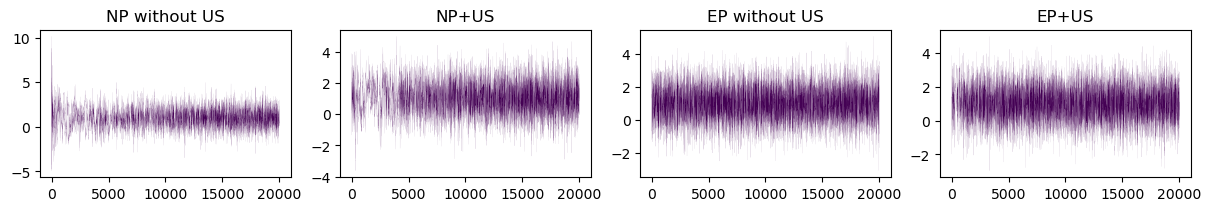

In [24]:
pfs.trace_plot_row([sams[:,0,0] for sams in samples], snames, lws=lw)

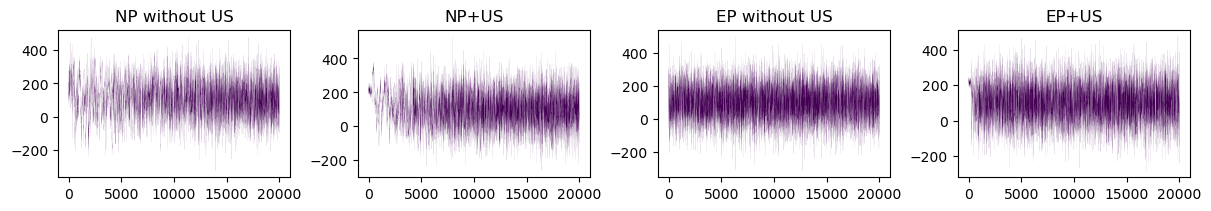

In [25]:
pfs.trace_plot_row([sams[:,0,-1] for sams in samples], snames, lws=lw)

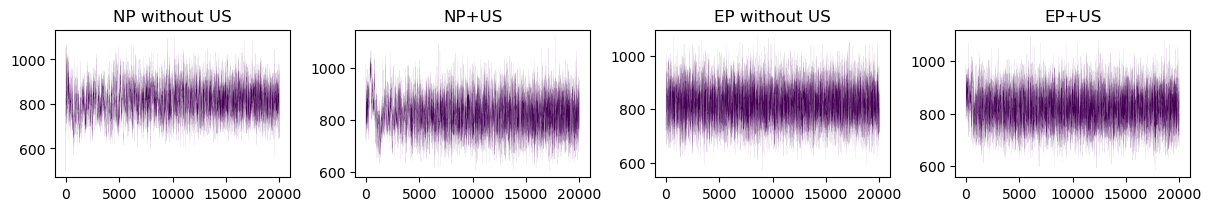

In [26]:
pfs.trace_plot_row([rs[:,0] for rs in radii], snames, lws=lw)

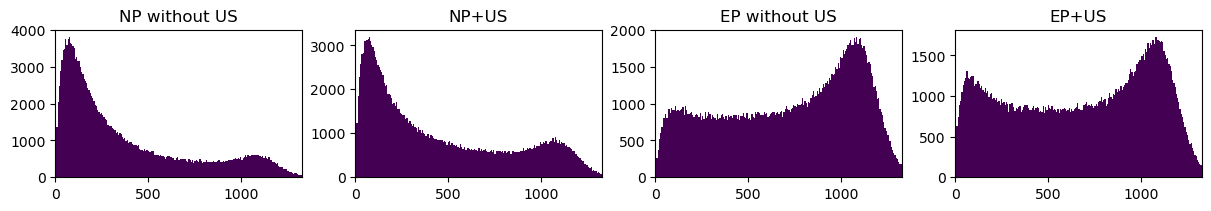

In [27]:
pfs.plot_step_hist_row(flat_steps, snames, same_range=True)

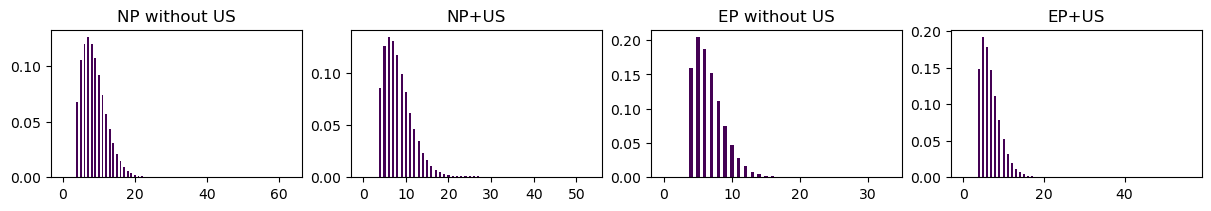

In [28]:
pfs.plot_tde_distr_row(tde, snames)

In [29]:
plt.rcParams["axes.prop_cycle"] = default_cycler